In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams.update({"figure.figsize": (10, 6), "font.size": 12})

In [4]:


DATA_PATH = "../data/raw/bank_transactions.csv"  # ensure this is the final dataset file
out_dir = "eda_outputs"
os.makedirs(out_dir, exist_ok=True)

df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])
print("Rows, cols:", df.shape)
print(df.dtypes)


Rows, cols: (174780, 9)
transaction_id                int64
customer_id                   int64
timestamp            datetime64[ns]
amount                      float64
merchant_category            object
merchant_id                  object
device_id                    object
location                     object
is_fraud                      int64
dtype: object


Quick peek and Basic Stats

In [13]:
# eda_step1_quick_peek.py
# show top and tail, basic describe
df.head(5)



,transaction_id,customer_id,timestamp,amount,merchant_category,merchant_id,device_id,location,is_fraud
0,159943,4575,2023-01-01 00:10:00,35747.94,Restaurants,M8906,iPhone_12,Ibadan,0
1,887,25,2023-01-01 00:10:00,41011.80,Restaurants,M4162,Windows_PC,Abuja,1
2,2381,68,2023-01-01 00:21:00,97614.54,Fashion,M9815,Samsung_S21,Lagos,0
3,121485,3455,2023-01-01 00:36:00,58350.27,Health,M9060,Infinix_Hot,Kaduna,0
4,88703,2519,2023-01-01 00:51:00,93539.79,Restaurants,M6597,Infinix_Hot,Kano,0


In [7]:
df.tail(5)

,transaction_id,customer_id,timestamp,amount,merchant_category,merchant_id,device_id,location,is_fraud
174775,159822,4571,2024-12-31 23:16:00,47682.08,Groceries,M2250,Tecno_Spark,Lagos,0
174776,109076,3092,2024-12-31 23:19:00,65360.36,Online Shopping,M2174,Tecno_Spark,Abuja,0
174777,22559,645,2024-12-31 23:25:00,9091.44,Utilities,M2566,Infinix_Hot,Kaduna,0
174778,108623,3080,2024-12-31 23:31:00,23503.23,Health,M2568,Samsung_S21,Kano,0
174779,65981,1882,2024-12-31 23:59:00,33220.29,Health,M1089,iPhone_12,Kaduna,0


In [10]:
# Basic numeric summary
df.describe(include=[np.number]).T




,count,mean,std,min,25%,50%,75%,max
transaction_id,174780.0,87390.500000,50454.784362,1.0,43695.7500,87390.500,131085.2500,174780.00
customer_id,174780.0,2491.272285,1439.924968,1.0,1249.0000,2481.000,3736.0000,5000.00
amount,174780.0,60571.968885,42781.991719,1.6,28815.7875,51287.025,83038.7125,410317.04
is_fraud,174780.0,0.057770,0.233308,0.0,0.0000,0.000,0.0000,1.00


In [11]:
# Categorical summary
df[["merchant_category","merchant_id","device_id","location"]].nunique()


merchant_category      10
merchant_id          9000
device_id               6
location                7
dtype: int64

In [12]:
df["merchant_category"].value_counts().head(10)

merchant_category
Health             18414
Travel             17760
Online Shopping    17661
Fashion            17629
Electronics        17573
Fuel               17412
Entertainment      17217
Restaurants        17173
Utilities          17096
Groceries          16845
Name: count, dtype: int64

## Missing values 

In [15]:
df.isnull().sum()

transaction_id       0
customer_id          0
timestamp            0
amount               0
merchant_category    0
merchant_id          0
device_id            0
location             0
is_fraud             0
dtype: int64

## Fraud Overall by Time

In [16]:
# 
total = len(df)
frauds = df["is_fraud"].sum()
print(f"Total txns: {total:,}  Fraudulent: {frauds:,}  Ratio: {frauds/total:.4%}")


Total txns: 174,780  Fraudulent: 10,097  Ratio: 5.7770%


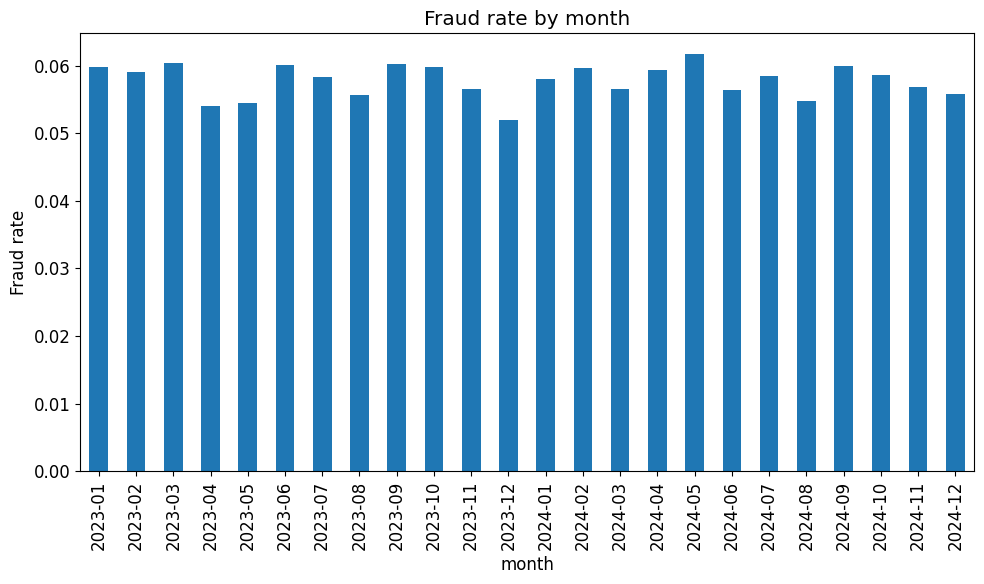

In [17]:

# Fraud ratio by month
df["month"] = df["timestamp"].dt.to_period("M")
fraud_by_month = df.groupby("month")["is_fraud"].mean().rename("fraud_rate")
fraud_by_month.plot(kind="bar")
plt.ylabel("Fraud rate")
plt.title("Fraud rate by month")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "fraud_rate_by_month.png"))
plt.show()


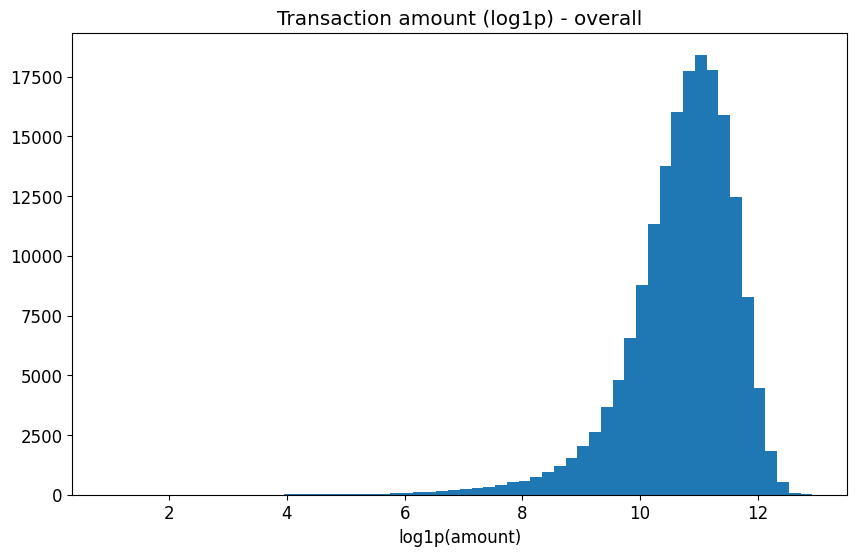

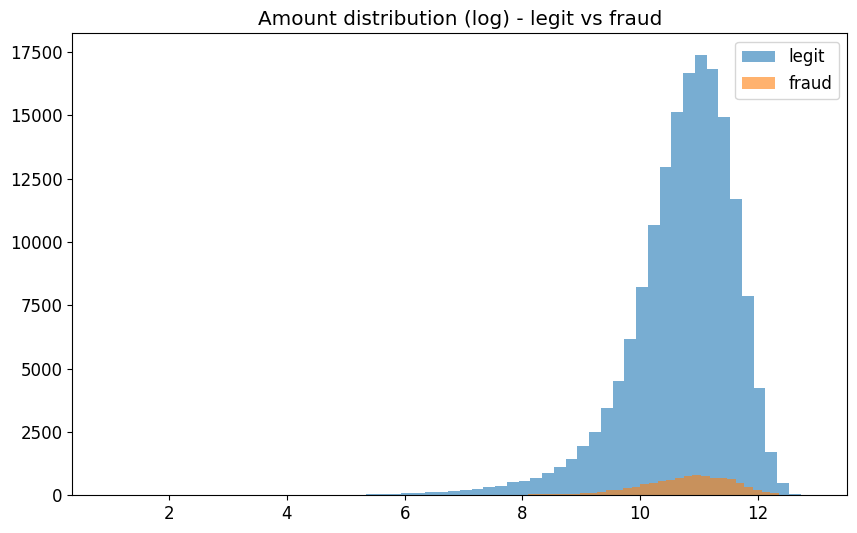

           count          mean    median           std        max
is_fraud                                                         
0         164683  60566.215737  51312.76  42735.007903  410317.04
1          10097  60665.803262  50915.69  43543.190231  361824.47


In [18]:
# amount_distribution
df["amount_log"] = np.log1p(df["amount"])

# overall
plt.hist(df["amount_log"], bins=60)
plt.title("Transaction amount (log1p) - overall")
plt.xlabel("log1p(amount)")
plt.savefig(os.path.join(out_dir, "amount_log_overall.png"))
plt.show()

# by fraud label
plt.hist(df[df["is_fraud"]==0]["amount_log"], bins=60, alpha=0.6, label="legit")
plt.hist(df[df["is_fraud"]==1]["amount_log"], bins=60, alpha=0.6, label="fraud")
plt.legend()
plt.title("Amount distribution (log) - legit vs fraud")
plt.savefig(os.path.join(out_dir, "amount_log_legit_vs_fraud.png"))
plt.show()

# Summary stats by label
print(df.groupby("is_fraud")["amount"].agg(["count","mean","median","std","max"]))


## Time of the day and weekend patters

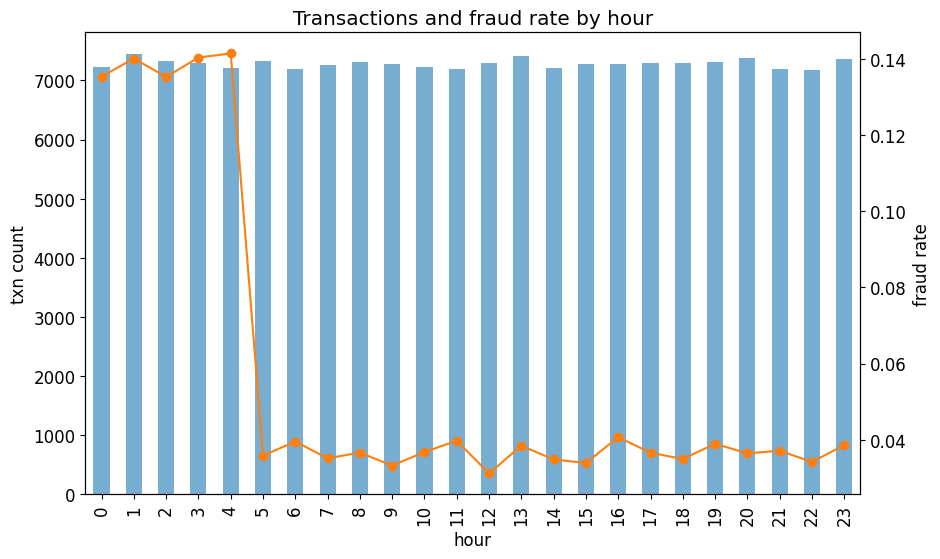

In [19]:
# time_patterns
df["hour"] = df["timestamp"].dt.hour
df["weekday"] = df["timestamp"].dt.day_name()

# Hourly volume & fraud rate
hour_counts = df.groupby("hour").size()
hour_fraud_rate = df.groupby("hour")["is_fraud"].mean()
fig, ax = plt.subplots()
ax2 = ax.twinx()
hour_counts.plot(ax=ax, kind="bar", color="C0", alpha=0.6)
hour_fraud_rate.plot(ax=ax2, color="C1", marker="o")
ax.set_ylabel("txn count")
ax2.set_ylabel("fraud rate")
plt.title("Transactions and fraud rate by hour")
plt.savefig(os.path.join(out_dir, "txns_and_fraud_by_hour.png"))
plt.show()



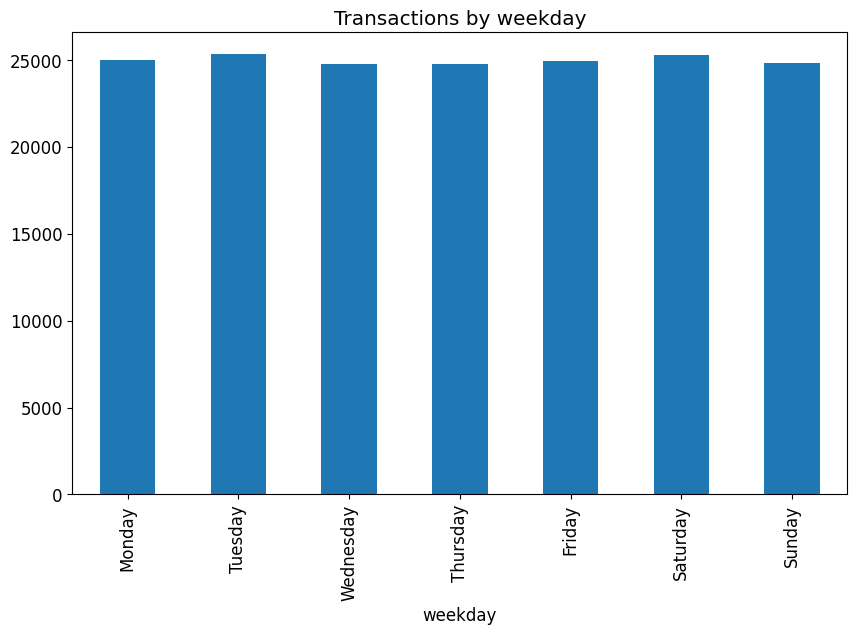

Fraud rate by weekday:
 weekday
Monday       0.058819
Tuesday      0.056089
Wednesday    0.056305
Thursday     0.059450
Friday       0.059272
Saturday     0.058670
Sunday       0.055788
Name: is_fraud, dtype: float64


In [20]:

# Weekday pattern
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
wd_counts = df.groupby("weekday").size().reindex(weekday_order)
wd_fraud = df.groupby("weekday")["is_fraud"].mean().reindex(weekday_order)
wd_counts.plot(kind="bar", title="Transactions by weekday")
plt.savefig(os.path.join(out_dir, "txns_by_weekday.png"))
plt.show()
print("Fraud rate by weekday:\n", wd_fraud)

## Merchant device and Localtion Analysis

In [22]:
# eda_step6_merchants_devices.py
top_merchants = df["merchant_id"].value_counts().head(5)
print("Top 20 merchants by txn count:\n", top_merchants)

Top 20 merchants by txn count:
 merchant_id
M2174    39
M3643    38
M2757    36
M4414    36
M7924    36
Name: count, dtype: int64


In [23]:
# Fraud rate by top merchant categories
cat = df.groupby("merchant_category")["is_fraud"].agg(["mean","count"]).sort_values("count", ascending=False)
print(cat)

                       mean  count
merchant_category                 
Health             0.057348  18414
Travel             0.056532  17760
Online Shopping    0.057415  17661
Fashion            0.055590  17629
Electronics        0.060946  17573
Fuel               0.057719  17412
Entertainment      0.056746  17217
Restaurants        0.057241  17173
Utilities          0.059254  17096
Groceries          0.059009  16845


In [24]:

# Devices: how many unique devices per customer average
dev_per_customer = df.groupby("customer_id")["device_id"].nunique()
print("Avg unique devices per customer:", dev_per_customer.mean())

Avg unique devices per customer: 5.9702


                 mean  count
device_id                   
Windows_PC   0.056926  29231
Infinix_Hot  0.058364  29213
MacBook_Pro  0.059075  29200
iPhone_12    0.056796  29069
Tecno_Spark  0.057633  29063
Samsung_S21  0.057820  29004


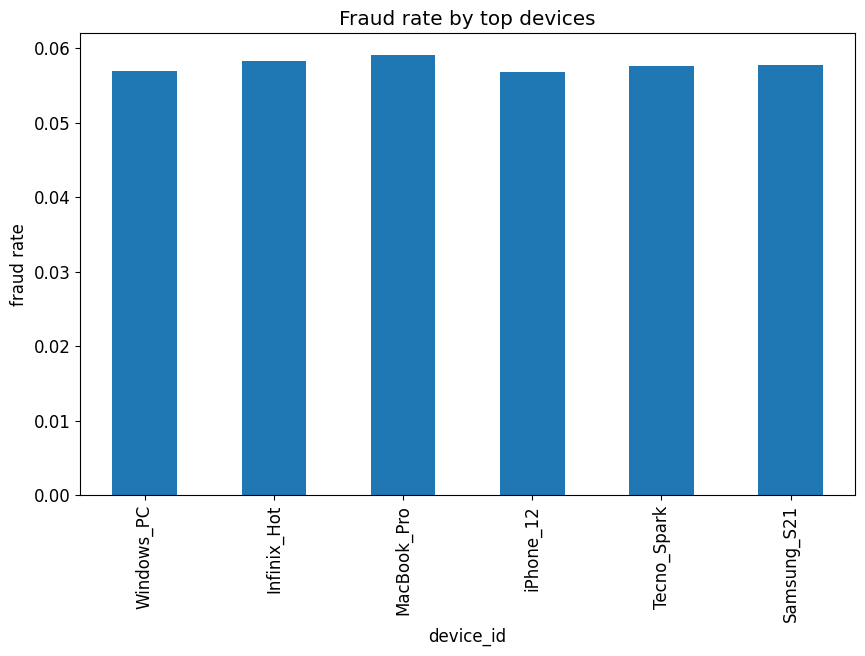

In [25]:
# Fraud rate by device (top 20 devices)
device_stats = df.groupby("device_id")["is_fraud"].agg(["mean","count"]).sort_values("count", ascending=False).head(30)
print(device_stats)
device_stats["mean"].plot(kind="bar", title="Fraud rate by top devices")
plt.ylabel("fraud rate")
plt.savefig(os.path.join(out_dir, "fraud_rate_by_top_devices.png"))
plt.show()


## Per-customer activity: distributions, high-volume users, churn

In [26]:
# customer_activity.py
cust_counts = df.groupby("customer_id").size().rename("txn_count")
cust_stats = cust_counts.describe()
print("Per-customer txn count stats:\n", cust_stats)

Per-customer txn count stats:
 count    5000.000000
mean       34.956000
std         8.978496
min        20.000000
25%        27.000000
50%        35.000000
75%        43.000000
max        50.000000
Name: txn_count, dtype: float64


In [27]:


# Customers with highest fraud counts
cust_fraud_counts = df.groupby("customer_id")["is_fraud"].sum().sort_values(ascending=False).head(20)
print("Customers with most fraud events:\n", cust_fraud_counts)

Customers with most fraud events:
 customer_id
1060    10
2404     9
2738     9
1997     9
2174     9
4628     8
3200     8
4063     8
2771     8
1669     8
3012     8
2979     8
4512     8
2238     7
2444     7
2346     7
2288     7
4464     7
1210     7
4204     7
Name: is_fraud, dtype: int64


In [29]:

# Explore one high-activity customer timeline
top_cust = cust_counts.sort_values(ascending=False).index[0]
sub = df[df["customer_id"] == top_cust].sort_values("timestamp")
sub.head(10)


,transaction_id,customer_id,timestamp,amount,merchant_category,merchant_id,device_id,location,is_fraud,month,amount_log,hour,weekday
3069,1869,53,2023-01-13 16:22:00,68356.04,Fuel,M9506,Samsung_S21,Kaduna,0,2023-01,11.132500,16,Friday
3492,1884,53,2023-01-15 09:58:00,45003.07,Groceries,M1738,Tecno_Spark,Kaduna,0,2023-01,10.714508,9,Sunday
5601,1901,53,2023-01-24 09:15:00,23950.43,Groceries,M8195,iPhone_12,Kaduna,0,2023-01,10.083783,9,Tuesday
9836,1903,53,2023-02-10 22:57:00,41544.89,Groceries,M5055,iPhone_12,Kaduna,0,2023-02,10.634554,22,Friday
14230,1877,53,2023-03-01 04:46:00,92154.41,Fuel,M9063,Tecno_Spark,Kaduna,0,2023-03,11.431232,4,Wednesday
16262,1860,53,2023-03-09 19:45:00,116665.98,Groceries,M6609,iPhone_12,Kaduna,0,2023-03,11.667079,19,Thursday
17581,1864,53,2023-03-15 04:37:00,31331.88,Groceries,M6253,iPhone_12,Kaduna,0,2023-03,10.352423,4,Wednesday
19285,1894,53,2023-03-22 09:55:00,37714.31,Electronics,M9828,iPhone_12,Kaduna,0,2023-03,10.537821,9,Wednesday
24785,1876,53,2023-04-14 21:07:00,107309.93,Groceries,M3935,Windows_PC,Kaduna,0,2023-04,11.583486,21,Friday
27364,1870,53,2023-04-25 13:52:00,84727.87,Online Shopping,M4044,Samsung_S21,Kaduna,0,2023-04,11.347212,13,Tuesday


In [31]:
# correlations.py
num_cols = ["amount","amount_log","hour"]
# Add numeric-encoded categories if helpful
corr = df[["amount","is_fraud"]].corr()
corr

,amount,is_fraud
amount,1.000000,0.000543
is_fraud,0.000543,1.000000


In [33]:
# You can compute simple aggregated features per customer as part of EDA:
cust_agg = df.groupby("customer_id").agg({
    "amount": ["mean","std","max","min"],
    "is_fraud": "sum",
    "transaction_id": "count"
})
cust_agg.columns = ["_".join(col).strip() for col in cust_agg.columns.values]
cust_agg.reset_index(inplace=True)
cust_agg.to_csv(os.path.join(out_dir, "customer_aggregates.csv"), index=False)
print("Saved customer aggregates to", os.path.join(out_dir, "customer_aggregates.csv"))

Saved customer aggregates to eda_outputs\customer_aggregates.csv


In [34]:
# eda_step9_sequences.py
# Find a fraudulent transaction and show preceding transactions for that customer
fraud_tx = df[df["is_fraud"]==1].sample(1).iloc[0]
cust = fraud_tx["customer_id"]
print("Example fraud txn:", fraud_tx.to_dict())



Example fraud txn: {'transaction_id': 114091, 'customer_id': 3243, 'timestamp': Timestamp('2024-06-20 03:13:00'), 'amount': 188733.78, 'merchant_category': 'Entertainment', 'merchant_id': 'M2508', 'device_id': 'iPhone_12', 'location': 'Kano', 'is_fraud': 1, 'month': Period('2024-06', 'M'), 'amount_log': 12.148098028098444, 'hour': 3, 'weekday': 'Thursday'}


In [36]:
history = df[(df["customer_id"]==cust) & (df["timestamp"] <= fraud_tx["timestamp"])].sort_values("timestamp").tail(10)
history[["transaction_id","timestamp","amount","merchant_category","device_id","location","is_fraud"]]

,transaction_id,timestamp,amount,merchant_category,device_id,location,is_fraud
77629,114075,2023-11-21 15:22:00,173449.21,Electronics,iPhone_12,Kano,0
81224,114083,2023-12-06 11:22:00,91130.23,Travel,Infinix_Hot,Kano,0
94489,114094,2024-01-30 06:40:00,181807.43,Entertainment,Tecno_Spark,Kano,0
101375,114105,2024-02-28 06:17:00,139465.19,Electronics,Windows_PC,Kano,0
106356,114087,2024-03-19 14:23:00,198091.57,Entertainment,Windows_PC,Kano,0
108006,114088,2024-03-26 19:04:00,79968.57,Travel,Infinix_Hot,Kano,0
118208,114110,2024-05-08 09:59:00,135890.50,Electronics,Samsung_S21,Kano,0
122707,114099,2024-05-27 01:14:00,143491.14,Online Shopping,MacBook_Pro,Kano,1
127350,114111,2024-06-15 17:31:00,55957.75,Online Shopping,iPhone_12,Kano,0
128398,114091,2024-06-20 03:13:00,188733.78,Entertainment,iPhone_12,Kano,1


In [37]:
# eda_step10_summary.py
summary = {
    "total_txns": len(df),
    "total_frauds": int(df["is_fraud"].sum()),
    "fraud_ratio": float(df["is_fraud"].mean()),
    "unique_customers": df["customer_id"].nunique(),
    "unique_merchants": df["merchant_id"].nunique() if "merchant_id" in df.columns else None
}
pd.DataFrame([summary]).to_csv(os.path.join(out_dir, "eda_summary.csv"), index=False)
with open(os.path.join(out_dir, "README_EDA.txt"), "w") as f:
    f.write("EDA summary\n")
    for k,v in summary.items():
        f.write(f"{k}: {v}\n")
print("Saved EDA summary and outputs to", out_dir)


Saved EDA summary and outputs to eda_outputs
